# Embeddings with the Schelling Model

A series of experiements with using embeddings to define agents in a simple schelling model.

See [schelling_embeddings2.py](schelling_embeddings2.py) for the Schelling model code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import glob

# Import the SchellingModel from your existing code file
#from schelling_embeddings2 import household_descriptions
from schelling_embeddings2 import SchellingModel

## Household Embedding similarity

Explore the embeddings before running the model later.

### Embedding example

Begin by doing some analysis of a few example embeddings used for demonstrative purposes

In [2]:
example_descriptions = pd.read_csv("household_descriptions-example.csv", header=None)[0].to_list()
example_descriptions


['A retired couple living alone in a semi-detached house in a suburban area, relying on state pensions and modest savings, strongly supporting the Conservative party',
 'An elderly couple residing in a suburban, semi-detached house, drawing income from their savings and their state pensions, voting for the Conservative party consistently',
 'A young, single professional renting a studio flat in a city centre, earning a salary around £35,000 from a career in marketing, voting for the Liberal Democrats and actively campaigning for environmental causes',
 'A large, multi-generational family residing in a terraced house, with the patriarch working as a manual labourer on a zero-hours contract, the matriarch a part-time carer, and several children, identifying as Labour supporters and strongly union-backed',
 'A single parent with three children, living in a council flat, surviving on a tight budget that includes Universal Credit and Child Tax Credits, and staunchly supporting the Labour pa

Calculate and examine the embeddings for those descriptions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


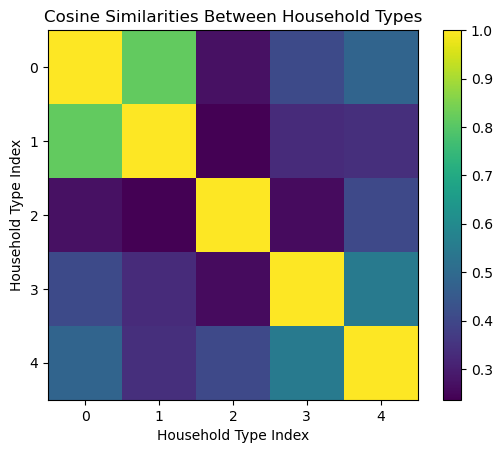

In [3]:
# Create a minimal model instance that doesn't run the main loop, but still loads embeddings.
model = SchellingModel(
    descriptions=example_descriptions,
    grid_size=1,
    num_agents=1,
    similarity_threshold=0.85,
    max_iters=0
)

# Retrieve the  household embeddings from the model
embeddings = model.description_embeddings

# Compute the similarity matrix
sim_matrix = cosine_similarity(embeddings)

# Plot the similarity matrix
plt.imshow(sim_matrix)  # By default uses a color scale
plt.colorbar()
plt.title("Cosine Similarities Between Household Types")
plt.xlabel("Household Type Index")
plt.ylabel("Household Type Index")
plt.savefig("similarity_matrix_example.pdf", bbox_inches='tight', dpi=128)
plt.show()

In [4]:
# Create a list of (type_i, type_j, similarity) for all unique pairs
pairs = []
for i in range(len(example_descriptions)):
    for j in range(i+1, len(example_descriptions)):
        pairs.append((i, j, sim_matrix[i][j]))

# Sort by similarity
pairs.sort(key=lambda x: x[2], reverse=True)

# Take the top 2 most similar
top_5 = pairs[:2]
# Take the bottom 5 least similar
bottom_5 = pairs[-2:]

# Convert to DataFrame
columns = ["Type1 Index", "Type2 Index", "Similarity", "Type1 Description", "Type2 Description"]
rows = []
for (i, j, sim) in top_5:
    rows.append((i, j, sim, example_descriptions[i], example_descriptions[j]))
for (i, j, sim) in bottom_5:
    rows.append((i, j, sim, example_descriptions[i], example_descriptions[j]))

df = pd.DataFrame(rows, columns=columns)

# Print a latex version of the table
print(df.to_latex(index=False, escape=False, column_format='r|r|r|l|l', float_format="%.2f"))

# Show the table
df

\begin{tabular}{r|r|r|l|l}
\toprule
Type1 Index & Type2 Index & Similarity & Type1 Description & Type2 Description \\
\midrule
0 & 1 & 0.82 & A retired couple living alone in a semi-detached house in a suburban area, relying on state pensions and modest savings, strongly supporting the Conservative party & An elderly couple residing in a suburban, semi-detached house, drawing income from their savings and their state pensions, voting for the Conservative party consistently \\
3 & 4 & 0.55 & A large, multi-generational family residing in a terraced house, with the patriarch working as a manual labourer on a zero-hours contract, the matriarch a part-time carer, and several children, identifying as Labour supporters and strongly union-backed & A single parent with three children, living in a council flat, surviving on a tight budget that includes Universal Credit and Child Tax Credits, and staunchly supporting the Labour party, particularly its more left-wing elements \\
2 & 3 & 0.26 & A 

,Type1 Index,Type2 Index,Similarity,Type1 Description,Type2 Description
0,0,1,0.816330,A retired couple living alone in a semi-detach...,"An elderly couple residing in a suburban, semi..."
1,3,4,0.548173,"A large, multi-generational family residing in...","A single parent with three children, living in..."
2,2,3,0.260055,"A young, single professional renting a studio ...","A large, multi-generational family residing in..."
3,1,2,0.236308,"An elderly couple residing in a suburban, semi...","A young, single professional renting a studio ..."


Note: **the plots showing the initial and final agent locations** for these example descriptions are generated by running [schelling_embeddings2.py](schelling_embeddings2.py) and then saving them manually.

### Full embedding set

Read a few hundred household descriptions produced by [create_household_descriptions.py](create_household_descriptions.py).

In [5]:
# Read all files named 'household_descriptions-N.csv' to a single pandas DataFrame
csv_files = glob.glob("household_descriptions-[0-9]*.csv")
print(f"Reading files: {csv_files}")
household_descriptions = []
for file in csv_files:
    df = pd.read_csv(file, header=None)
    # Append the DataFrame to the list
    household_descriptions.append(df)
# Concatenate all DataFrames into a single DataFrame
household_descriptions_df = pd.concat(household_descriptions, ignore_index=True)
del household_descriptions  # (for tidying, I use this variable later)
# Name the first column 'description' and any other columns can be blank
household_descriptions_df.columns = ['description'] + [f'Unnamed: {i}' for i in range(1, len(household_descriptions_df.columns))]
household_descriptions_df

Reading files: ['household_descriptions-149.csv', 'household_descriptions-151.csv']


,description
0,A retired couple living in a semi-detached hou...
1,"A single mother with two children, residing in..."
2,A family of four in a detached house in Surrey...
3,A student household of three sharing a terrace...
4,A couple in their 50s living in a bungalow in ...
...,...
299,"A single mother with two children, residing in..."
300,"A family of three with a single breadwinner, r..."
301,"A couple with one child, living in a detached ..."
302,A lone individual renting a studio flat in Nor...


In [6]:
# Need to work with a list from now on
household_descriptions = household_descriptions_df['description'].to_list()

Calculate the embeddings


In [7]:
# Create a minimal model instance. Set grid_size=1, num_agents=1, max_iters=0
# so it doesn't run the main loop, but still loads embeddings.
model = SchellingModel(
    descriptions=household_descriptions,
    grid_size=1,
    num_agents=1,
    similarity_threshold=0.85,
    max_iters=0
)

# Retrieve the 10 household embeddings from the model
embeddings = model.description_embeddings

# Compute the similarity matrix
sim_matrix = cosine_similarity(embeddings)

Plot the similarity matrix (a bit big for anything meaningful)

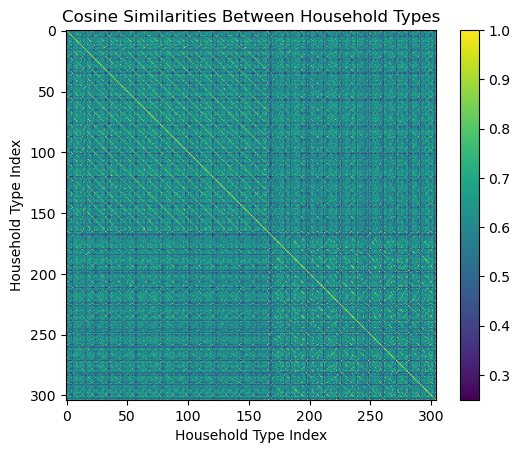

In [8]:
# Plot the similarity matrix
plt.imshow(sim_matrix)  # By default uses a color scale
plt.colorbar()
plt.title("Cosine Similarities Between Household Types")
plt.xlabel("Household Type Index")
plt.ylabel("Household Type Index")
plt.show()

Show the most- and least-similar pairs of households

In [9]:
# Create a list of (type_i, type_j, similarity) for all unique pairs
pairs = []
for i in range(len(household_descriptions)):
    for j in range(i+1, len(household_descriptions)):
        pairs.append((i, j, sim_matrix[i][j]))

# Sort by similarity
pairs.sort(key=lambda x: x[2], reverse=True)

# Take the top 5 most similar
top_5 = pairs[:5]
# Take the bottom 5 least similar
bottom_5 = pairs[-5:]

# Convert to DataFrame
columns = ["Type1 Index", "Type2 Index", "Similarity", "Type1 Description", "Type2 Description"]
rows = []
for (i, j, sim) in top_5:
    rows.append((i, j, sim, household_descriptions[i], household_descriptions[j]))
for (i, j, sim) in bottom_5:
    rows.append((i, j, sim, household_descriptions[i], household_descriptions[j]))

df = pd.DataFrame(rows, columns=columns)

# Show the table
df

,Type1 Index,Type2 Index,Similarity,Type1 Description,Type2 Description
0,1,165,1.000000,"A single mother with two children, residing in...","A single mother with two children, residing in..."
1,0,164,1.000000,A retired couple living in a semi-detached hou...,A retired couple living in a semi-detached hou...
2,198,257,0.998934,"A family of three with two working parents, li...","A family of three with two working parents, li..."
3,204,243,0.998199,A lone individual living in a shared house in ...,A lone individual living in a shared house in ...
4,31,81,0.997654,A household of five in a large detached house ...,A household of five in a large detached house ...
5,76,283,0.272989,"A single mother with one child, residing in a ...",A group of five friends sharing a large house ...
6,120,199,0.272453,"A single mother with one child, residing in a ...",A group of four friends sharing a large house ...
7,54,283,0.268171,"A single mother with one child, residing in a ...",A group of five friends sharing a large house ...
8,98,283,0.258713,"A single mother with one child, residing in a ...",A group of five friends sharing a large house ...
9,120,283,0.249893,"A single mother with one child, residing in a ...",A group of five friends sharing a large house ...


## Run the model

Run he model, visualise the changing locations of the agents and then plot a graph to show how happiness changes.

Iteration 0: 75 happy agents
Iteration 1: 90 happy agents
Iteration 2: 107 happy agents
Iteration 3: 124 happy agents
Iteration 4: 133 happy agents
Iteration 5: 136 happy agents
Iteration 6: 136 happy agents
Iteration 7: 148 happy agents
Iteration 8: 152 happy agents
Iteration 9: 159 happy agents
Iteration 10: 155 happy agents
Iteration 11: 151 happy agents
Iteration 12: 156 happy agents
Iteration 13: 160 happy agents
Iteration 14: 148 happy agents
Iteration 15: 153 happy agents
Iteration 16: 164 happy agents
Iteration 17: 173 happy agents
Iteration 18: 175 happy agents
Iteration 19: 187 happy agents
Iteration 20: 185 happy agents
Iteration 21: 177 happy agents
Iteration 22: 189 happy agents
Iteration 23: 181 happy agents
Iteration 24: 175 happy agents
Iteration 25: 180 happy agents
Iteration 26: 193 happy agents
Iteration 27: 193 happy agents
Iteration 28: 198 happy agents
Iteration 29: 204 happy agents
Iteration 30: 211 happy agents
Iteration 31: 213 happy agents
Iteration 32: 218 ha

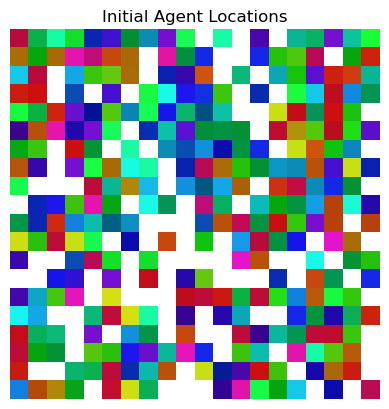

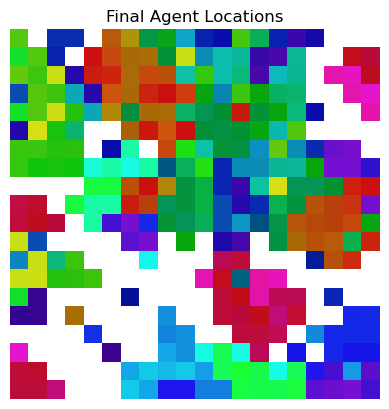

In [10]:

# --- Step 2: Create and run the model
model = SchellingModel(household_descriptions,
                           grid_size=20,
                           num_agents=300,
                           similarity_threshold=0.65,
                           max_iters=200)

# Save initial positions before running the simulation
initial_positions = [(agent.pos, agent.desc_idx) for agent in model.agents]

# Run the simulation (updates agent positions)
model.run(do_plots=False)

# Save final positions
final_positions = [(agent.pos, agent.desc_idx) for agent in model.agents]

# --- Step 3: Plotting function
def plot_agent_positions(agent_data, title, rgb_map, grid_size=20):
    img = np.ones((grid_size, grid_size, 3))  # white background
    for (x, y), desc_idx in agent_data:
        rgb = rgb_map[desc_idx]
        scaled = (rgb - rgb_map.min()) / (rgb_map.max() - rgb_map.min())
        img[x, y] = scaled
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.savefig(f"{title.replace(" ", "_")}.pdf", bbox_inches='tight', dpi=128)
    plt.show()

# --- Step 4: Show both grids
plot_agent_positions(initial_positions, "Initial Agent Locations", model.rgb_map)
plot_agent_positions(final_positions, "Final Agent Locations", model.rgb_map)


/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_62927/2950375456.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


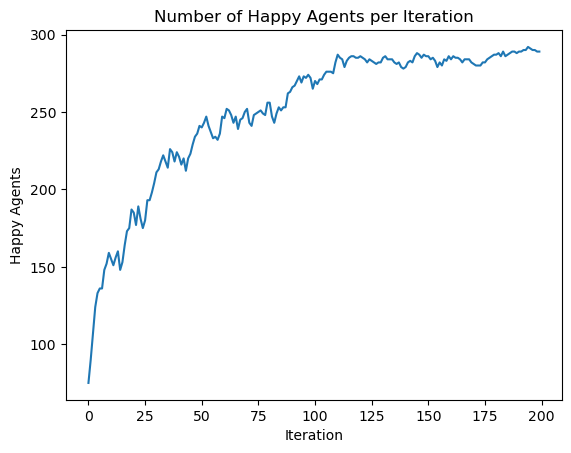

In [11]:
# Plot the happiness graph too
fig = model.plot_happiness(return_fig=True)
fig.savefig("Happiness.pdf", bbox_inches='tight', dpi=128)
fig.show()